In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

from tqdm import tqdm

from aegear.model import EfficientUNet, TrajectoryPredictionNet
from aegear.datasets import FishHeatmapSequenceDataset

In [2]:
# Cell 2: Load EfficientUNet model (assume pretrained weights exist)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = EfficientUNet()
model.load_state_dict(torch.load("../data/models/model_efficient_unet_2025-04-04.pth", map_location=device))
model.eval()
model.to(device);

In [3]:
dataset = FishHeatmapSequenceDataset(
    tracking_json_path="../data/training/tracking_E7_filtered.json",
    unet_model=model,
    device=device,
    history_len=25,
    future_len=5,
    stride=5,
    interpolation_smoothness=5.0,
    max_span=300,
    cache_path="../data/models/grutracker/training_cache",
)

val_fraction = 0.2
val_size = int(len(dataset) * val_fraction)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Loaded cached sequence data from ../data/models/grutracker/training_cache
Train dataset size: 28620
Validation dataset size: 7155


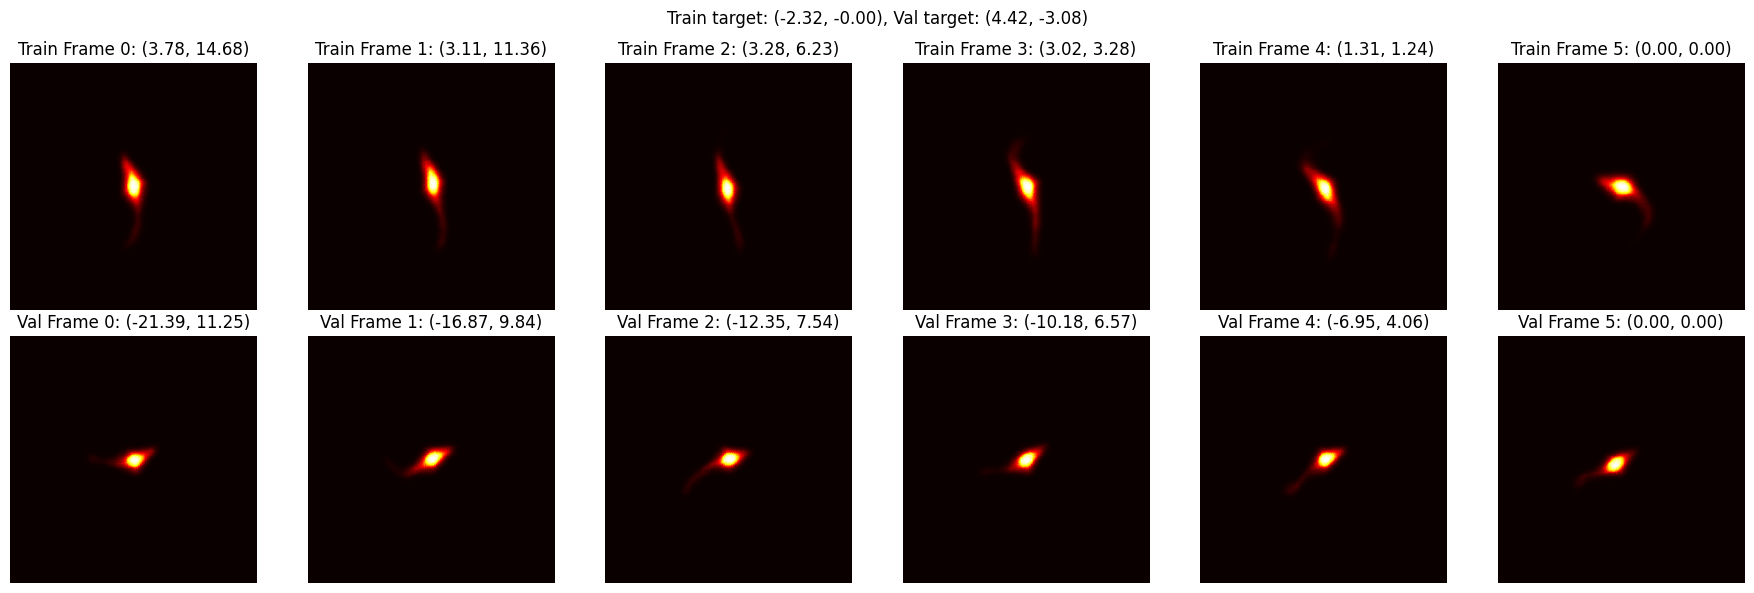

In [4]:
# Pick a random sample from the training and validation datasets
import random

random_train_idx = random.randint(0, len(train_dataset) - 1)
random_val_idx = random.randint(0, len(val_dataset) - 1)

train_sample = train_dataset[random_train_idx]
val_sample = val_dataset[random_val_idx]

train_heatmaps, train_past, train_future = train_sample
val_heatmaps, val_past, val_future = val_sample

T = train_heatmaps.shape[0]
fig, axs = plt.subplots(2, T, figsize=(T * 3, 6))

for i in range(T):
    t_offset = train_past[i, :]
    v_offset = val_past[i, :]

    axs[0, i].imshow(train_heatmaps[i, 0], cmap='hot')
    axs[0, i].set_title(f"Train Frame {i}: ({t_offset[0]:.2f}, {t_offset[1]:.2f})")
    axs[0, i].axis('off')

    axs[1, i].imshow(val_heatmaps[i, 0], cmap='hot')
    axs[1, i].set_title(f"Val Frame {i}: ({v_offset[0]:.2f}, {v_offset[1]:.2f})")
    axs[1, i].axis('off')

plt.suptitle(f"Train target: ({train_future[0, 0]:.2f}, {train_future[0, 1]:.2f}), Val target: ({val_future[0, 0]:.2f}, {val_future[0, 1]:.2f})")
plt.tight_layout()
plt.show()

In [5]:
# Cell 6: Instantiate model, loss, optimizer
tracker = TrajectoryPredictionNet(pred_steps=1).to(device)
optimizer = torch.optim.Adam(tracker.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

In [6]:
model_dir = '../data/models/grutracker'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'

os.makedirs(model_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

writer = SummaryWriter(log_dir=log_dir, flush_secs=1)
best_val_loss = float('inf')
losses = []

epochs = 50
epoch_save_interval = 10

epoch_bar = tqdm(range(epochs), desc="Epochs")
for epoch in epoch_bar:
    tracker.train()
    train_loss = 0.0
    
    for heatmaps, relative_offsets, coords in train_loader:
        heatmaps = heatmaps.to(device)  # (B, T, 1, 224, 224)
        relative_offsets = relative_offsets.to(device) # (B, T, 2)
        coords = coords.to(device)      # (B, 2)

        preds = tracker(heatmaps, relative_offsets)
        loss = loss_fn(preds, coords)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    tracker.eval()
    val_loss = 0.0

    with torch.no_grad():
        for heatmaps, relative_offsets, coords in val_loader:
            heatmaps = heatmaps.to(device)
            relative_offsets = relative_offsets.to(device)
            coords = coords.to(device)

            preds = tracker(heatmaps, relative_offsets)
            loss = loss_fn(preds, coords)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    losses.append((train_loss, val_loss))

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    epoch_bar.set_postfix(train_loss=train_loss, val_loss=val_loss, best_val_loss=best_val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(tracker.state_dict(), f'{model_dir}/best_model.pth')

    if (epoch + 1) % epoch_save_interval == 0:
        torch.save(tracker.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))

writer.close()

Epochs: 100%|██████████| 50/50 [10:17<00:00, 12.35s/it, best_val_loss=1.17, train_loss=0.685, val_loss=1.16]


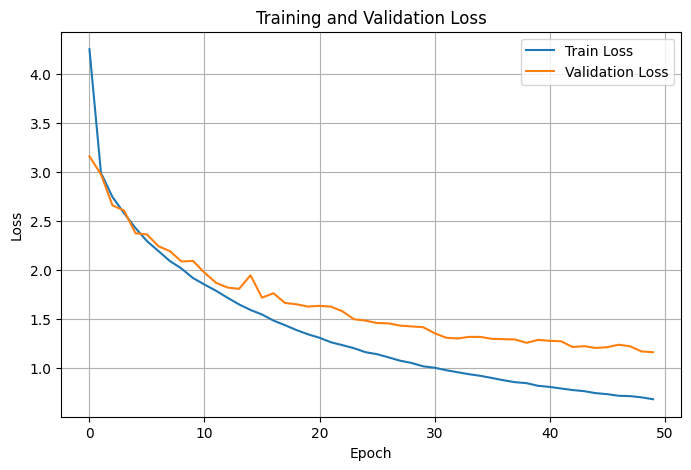

In [7]:
# 7. Plotting the losses
import matplotlib.pyplot as plt

train_losses, val_losses = zip(*losses)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def visualize_prediction_grid(dataset, model, device="cuda", rows=4, cols=8):
    model.eval()
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))

    for i in range(rows * cols):
        r, c = divmod(i, cols)
        ax = axs[r, c]

        # Get data
        heatmaps, rel_offsets, target = dataset[i]
        heatmaps = heatmaps.unsqueeze(0).to(device)       # [1, T, 1, H, W]
        rel_offsets = rel_offsets.unsqueeze(0).to(device) # [1, T, 2]
        target = target.cpu().numpy()

        # Prediction
        with torch.no_grad():
            pred = model(heatmaps, rel_offsets).squeeze(0).cpu().numpy()

        pred = pred[0]
        target = target[0]  

        # Get the middle coordinate of the image resolution
        h, w = heatmaps.shape[3:]
        center_x = w // 2
        center_y = h // 2

        center = np.array([center_x, center_y])

        pred = center - pred[0]
        target = center - target


        # Last input frame
        frame = heatmaps[0, -1, 0].cpu().numpy()
        ax.imshow(frame, cmap='hot')
        ax.scatter(*target, c='green', marker='x', s=40, label='GT')
        ax.scatter(*pred, c='blue', marker='o', s=20, label='Pred')
        ax.axis('off')
        ax.set_title(f"#{i}", fontsize=8)

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

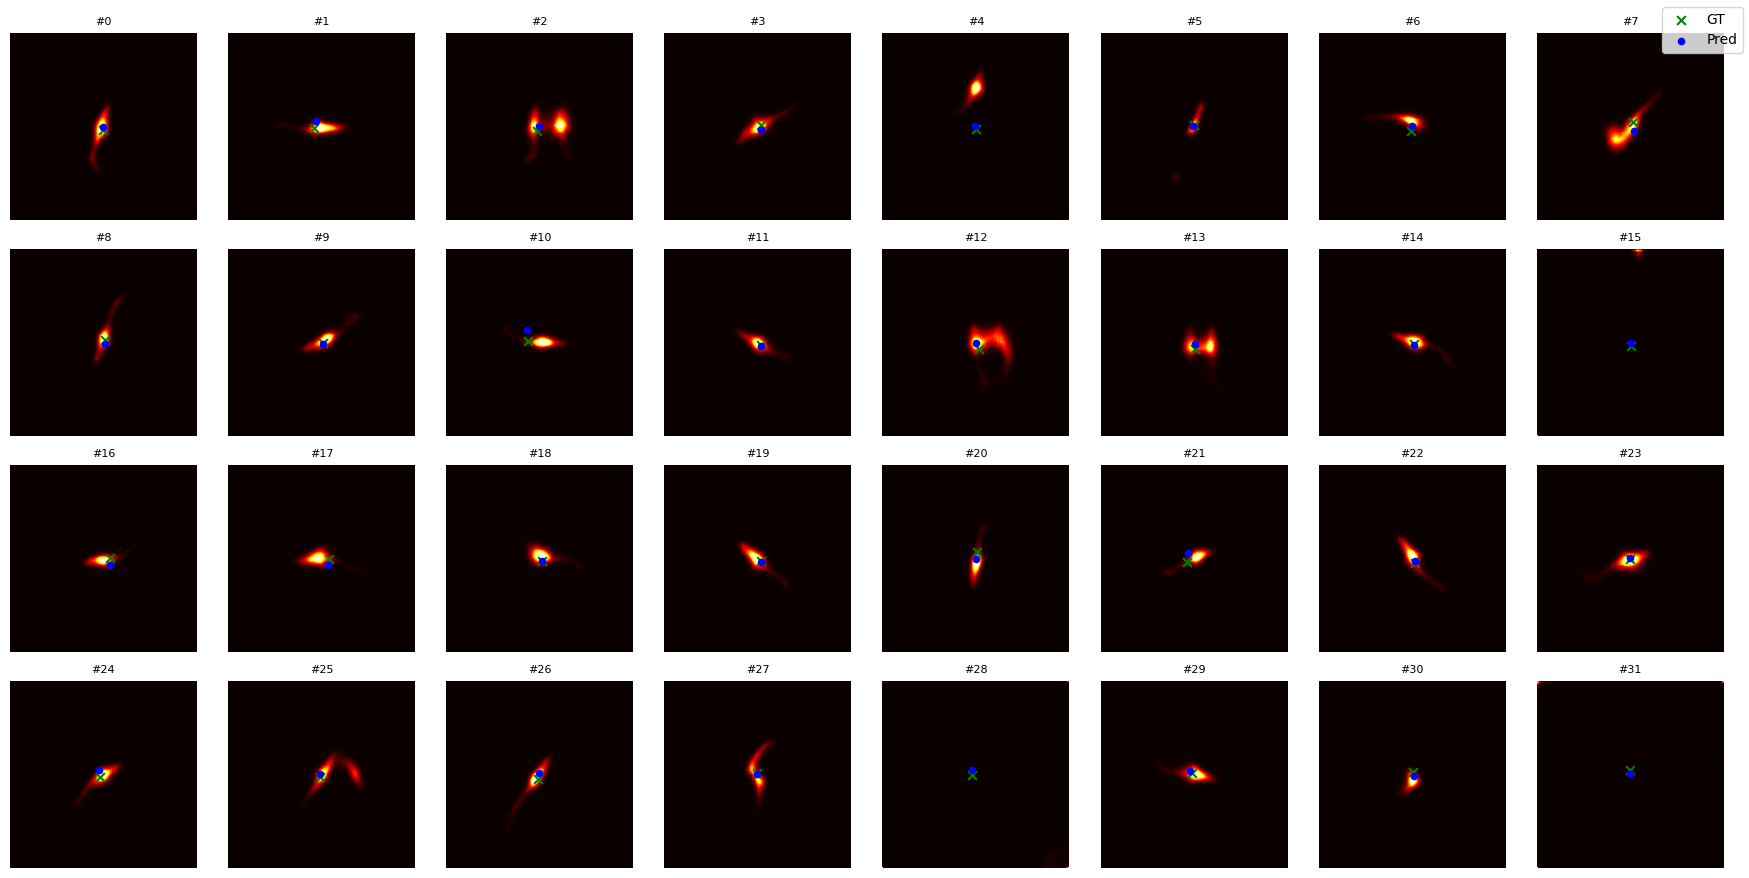

In [9]:
visualize_prediction_grid(val_dataset, tracker, device="cuda", rows=4, cols=8)

In [10]:
def evaluate_and_plot_extremes(dataset, model, device="cuda", metric="l2"):
    model.eval()
    errors = []

    # Step 1: Collect all predictions + losses
    for i in range(len(dataset)):
        heatmaps, rel_offsets, target = dataset[i]
        heatmaps = heatmaps.unsqueeze(0).to(device)
        rel_offsets = rel_offsets.unsqueeze(0).to(device)
        target = target.cpu().numpy()

        with torch.no_grad():
            pred = model(heatmaps, rel_offsets).squeeze(0).cpu().numpy()

        pred = pred[0]
        target = target[0]

        if metric == "l2":
            error = np.linalg.norm(pred - target)
        else:
            error = ((pred - target) ** 2).mean()

        errors.append((error, i, pred, target))

    # Step 2: Sort by error
    errors.sort(key=lambda x: x[0])
    best = errors[:5]
    mid = errors[len(errors)//2 - 2:len(errors)//2 + 3]
    worst = errors[-5:]

    def _plot_group(name, group):
        fig, axs = plt.subplots(1, 5, figsize=(15, 3))
        for j, (err, i, pred, target) in enumerate(group):
            heatmaps, _, _ = dataset[i]
            frame = heatmaps[-1, 0].cpu().numpy()

            h, w = heatmaps.shape[2:]
            center_x, center_y = w // 2, h // 2
            pred_disp = pred + np.array([center_x, center_y])
            target_disp = target + np.array([center_x, center_y])

            ax = axs[j]
            ax.imshow(frame, cmap='hot')
            ax.scatter(*target_disp, c='green', marker='x', s=20, label='GT')
            ax.scatter(*pred_disp, c='blue', marker='o', s=20, label='Pred')
            ax.set_title(f"#{i}\nErr: {err:.2f}", fontsize=8)
            ax.axis('off')
        fig.suptitle(name, fontsize=14)
        plt.tight_layout()
        plt.show()

    _plot_group("Worst 5 Predictions", worst)
    _plot_group("Median 5 Predictions", mid)
    _plot_group("Best 5 Predictions", best)


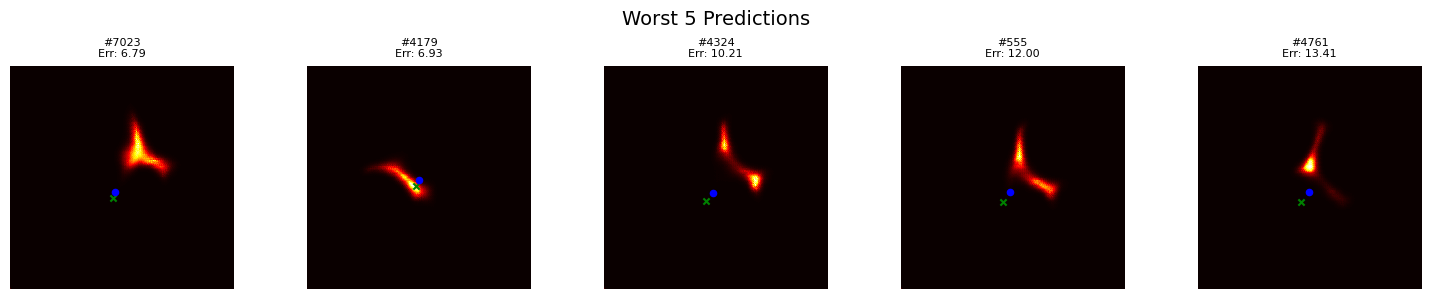

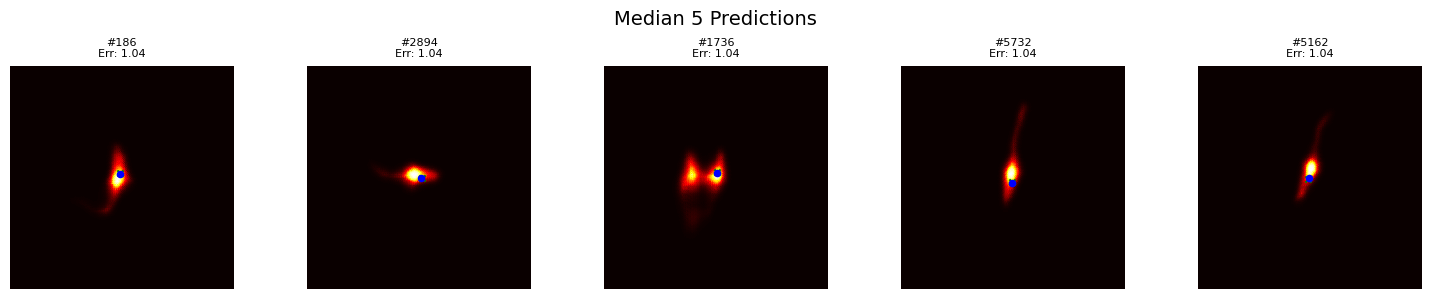

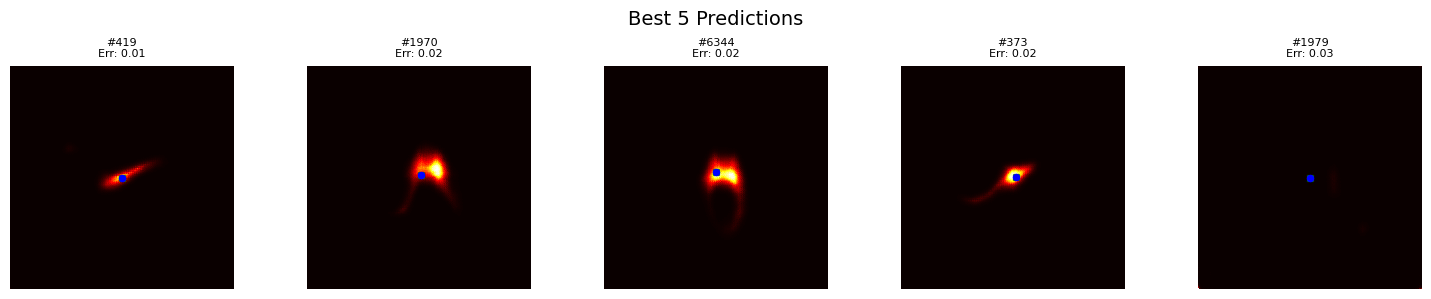

In [11]:
evaluate_and_plot_extremes(val_dataset, tracker)

In [12]:
def visualize_temporal_debug_grid(dataset, model, device="cuda", rows=3, cols=3, canvas_size=300):
    """
    Create a grid of debug visualizations for the temporal model.
    
    For each sample, this function:
      - Creates a black canvas (300x300)
      - Pastes each history heatmap onto the canvas shifted by its relative offset
        (so that the heatmap’s center appears at canvas_center + offset)
      - Uses a ghosting effect (older frames are more transparent)
      - Draws colored circle markers for each history frame (colors from 'jet')
      - Draws a cyan line connecting the history positions (trajectory)
      - Computes the future prediction and ground truth (both relative to f0)
      - Draws dashed lines from the canvas center to the predicted and GT points,
        and marks them with a blue circle (prediction) and a green cross (GT)
    """
    model.eval()
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3.5))
    center = np.array([canvas_size // 2, canvas_size // 2])
    
    # Iterate over grid samples
    total_samples = rows * cols
    for i in range(total_samples):
        # Get the i-th sample from the dataset
        heatmaps, rel_offsets, target = dataset[i]
        # heatmaps: [T, 1, H, W], rel_offsets: [T, 2], target: [2]
        T, C, H, W = heatmaps.shape
        # Convert tensors to device and then to CPU numpy arrays as needed.
        heatmaps = heatmaps.to(device).unsqueeze(0)    # [1, T, 1, H, W]
        rel_offsets = rel_offsets.to(device).unsqueeze(0)  # [1, T, 2]
        with torch.no_grad():
            pred = model(heatmaps, rel_offsets).squeeze(0).cpu().numpy()  # [2]
        heatmaps = heatmaps.squeeze(0).cpu()  # [T, 1, H, W]
        rel_offsets = rel_offsets.squeeze(0).cpu().numpy()  # [T, 2]
        target = target.cpu().numpy()[0]

        pred = pred[0]
        
        # Create a blank canvas
        canvas = np.zeros((canvas_size, canvas_size), dtype=np.float32)
        
        # List to store absolute positions of history frames (for trajectory)
        positions = []
        
        # Paste each history heatmap with ghosting:
        for t in range(T):
            # Compute absolute position in canvas: center plus relative offset
            pos = center + rel_offsets[t]  # This is where the center of the heatmap should go
            positions.append(pos)
            # Top-left corner for pasting: subtract half of heatmap size
            top = int(pos[1] - H // 2)
            left = int(pos[0] - W // 2)
            
            # Get heatmap image for frame t (shape H x W)
            hm = heatmaps[t, 0].numpy()
            
            # Define an alpha that increases with t (newer frames are less transparent)
            alpha = 0.15 + 0.25 * ((t + 1) / T)  # adjust as needed
            
            # Determine the region of the canvas to paste (handle boundaries)
            y1 = max(0, top)
            y2 = min(canvas_size, top + H)
            x1 = max(0, left)
            x2 = min(canvas_size, left + W)
            
            # Corresponding region in the heatmap:
            hm_y1 = y1 - top
            hm_y2 = hm_y1 + (y2 - y1)
            hm_x1 = x1 - left
            hm_x2 = hm_x1 + (x2 - x1)
            
            # Alpha-blend the heatmap region onto the canvas
            canvas[y1:y2, x1:x2] = (1 - alpha) * canvas[y1:y2, x1:x2] + alpha * hm[hm_y1:hm_y2, hm_x1:hm_x2]
        
        # Compute absolute future prediction and ground truth (both are relative offsets)
        pred_abs = center + pred
        target_abs = center + target
        
        # Plot the canvas and overlay markers/lines:
        ax = axs.flatten()[i]
        ax.imshow(canvas, cmap="hot", origin="upper")
        
        # Draw markers for each history frame using a colormap (jet)
        marker_cmap = plt.get_cmap("jet")
        for t, pos in enumerate(positions):
            color = marker_cmap(t / (T - 1))  # vary color along history
            ax.plot(pos[0], pos[1], marker="o", color=color, markersize=6)
        
        # Draw trajectory line connecting history positions
        traj = np.array(positions)
        ax.plot(traj[:, 0], traj[:, 1], linestyle="-", color="cyan", linewidth=1)
        
        # Draw dashed lines from canvas center (f0 center) to predicted and GT future positions
        ax.plot([center[0], pred_abs[0]], [center[1], pred_abs[1]], linestyle="--", color="blue", linewidth=1)
        ax.plot([center[0], target_abs[0]], [center[1], target_abs[1]], linestyle="--", color="green", linewidth=1)
        
        # Mark predicted and ground truth future positions
        ax.plot(pred_abs[0], pred_abs[1], marker="o", color="blue", markersize=8, label="Pred")
        ax.plot(target_abs[0], target_abs[1], marker="x", color="green", markersize=8, label="GT")
        
        ax.set_title(f"Sample #{i}", fontsize=10)
        ax.axis("off")
    
    # Create a common legend for the grid (if needed)
    handles = [
        plt.Line2D([0], [0], marker="o", color="blue", linestyle="--", label="Pred"),
        plt.Line2D([0], [0], marker="x", color="green", linestyle="--", label="GT")
    ]
    fig.legend(handles=handles, loc="upper right", fontsize=10)
    plt.tight_layout()
    plt.show()

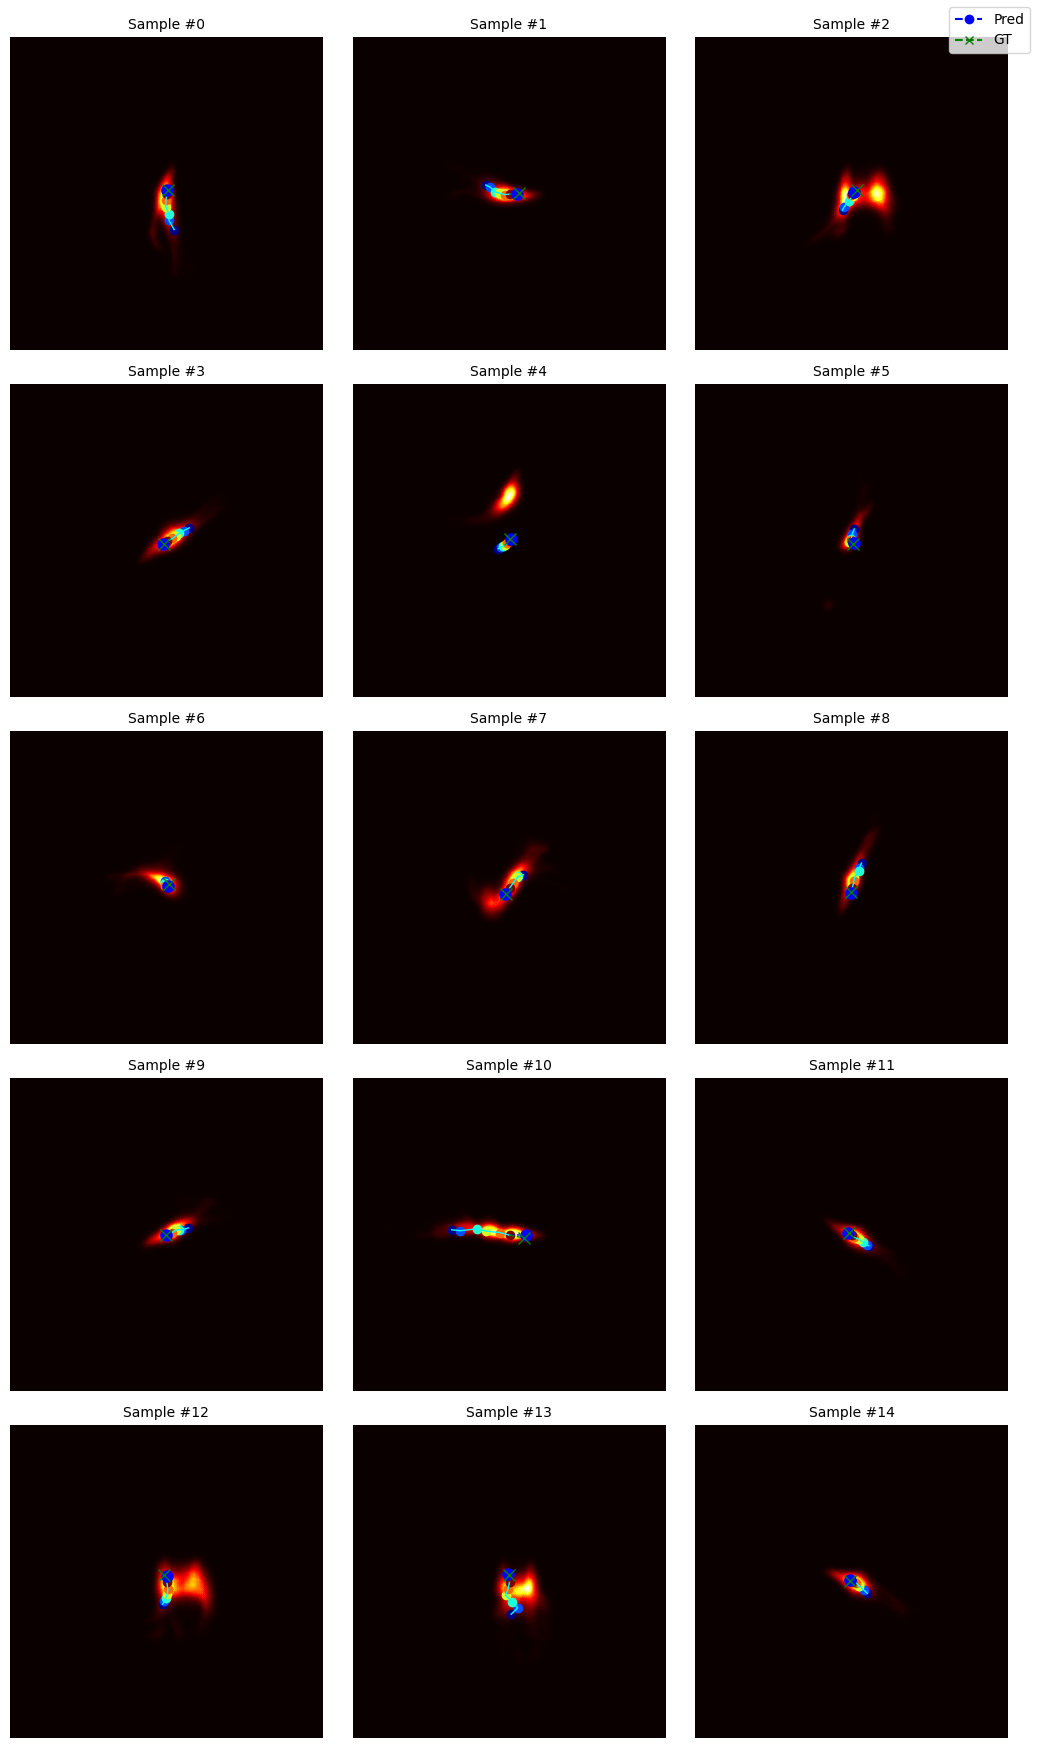

In [13]:
visualize_temporal_debug_grid(val_dataset, tracker, rows=5, cols=3, canvas_size=300)
